# Comparison Between TreeValue and DM-Tree

In this section, we will compare the feature and performance of the [dm-tree](https://github.com/deepmind/tree) library, which is developed by deepmind.

Before starting the comparison, let us define some thing.

In [1]:
origin = {'a': 1, 'b': 2, 'c': {'x': 3, 'y': 4}}

## Mapping Operation

Mapping operation is quite common in the processing of trees. A mapping function should be provided to create a new tree based on the mapped tree.

### TreeValue's mapping

In TreeValue, mapping is provided to simply create a new tree.

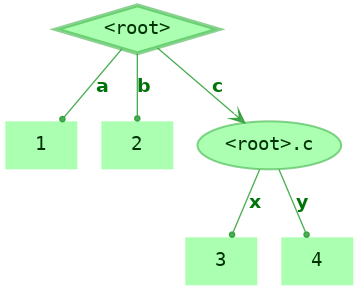

In [2]:
from treevalue import FastTreeValue, mapping

tv = FastTreeValue(origin)
tv

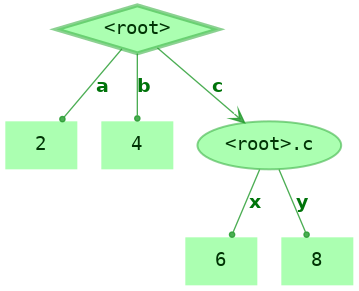

In [3]:
mapping(tv, lambda x: x * 2)

Here is the performance test.

In [4]:
%timeit mapping(tv, lambda x: x * 2)

2.61 µs ± 39.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In order to support the cased that the mapped value is related to both path and value of each node, we can use the 'path mapping mode' by simply use the second parameter of the mapping function.

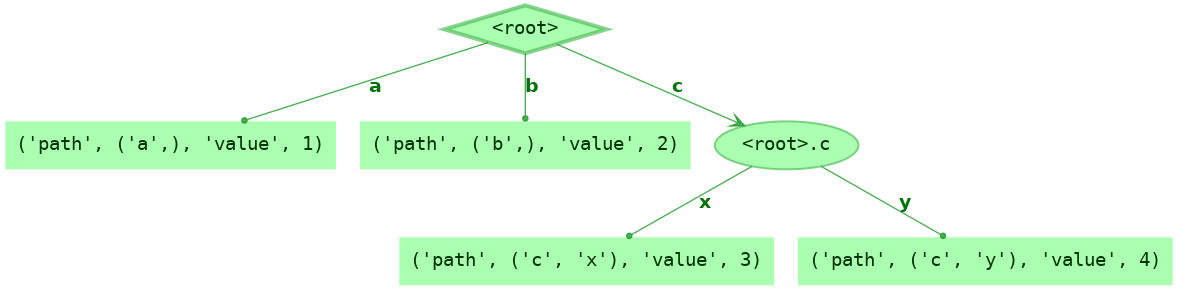

In [5]:
mapping(tv, lambda x, p: ('path', p, 'value', x))

And here is the performance

In [6]:
%timeit mapping(tv, lambda x, p: ('path', p, 'value', x))

2.82 µs ± 73.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### DM-Tree's mapping

In DM-Tree, mapping operation is supported by [map_structure](https://tree.readthedocs.io/en/latest/api.html#tree.map_structure) function.

In [7]:
from tree import map_structure

In [8]:
map_structure(lambda x: x * 2, origin)

{'a': 2, 'b': 4, 'c': {'x': 6, 'y': 8}}

This is the performance of `map_structure`, obviously much slower than `mapping` in TreeValue.

In [9]:
%timeit map_structure(lambda x: x * 2, origin)

18.7 µs ± 224 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


To supported the second situation in the last section, [map_structure_with_path](https://tree.readthedocs.io/en/latest/api.html#tree.map_structure_with_path) can be used.

In [10]:
from tree import map_structure_with_path

In [11]:
map_structure_with_path(lambda path, x: ('path', path, 'value', x), origin)

{'a': ('path', ('a',), 'value', 1),
 'b': ('path', ('b',), 'value', 2),
 'c': {'x': ('path', ('c', 'x'), 'value', 3),
  'y': ('path', ('c', 'y'), 'value', 4)}}

Here is the performance.

In [12]:
%timeit map_structure_with_path(lambda path, x: ('path', path, 'value', x), origin)

40.8 µs ± 682 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Flatten and Unflatten

In tree operations, flatten is often used to linearly expand the tree structure for operations such as parallel processing. Based on flatten, unflatten is its inverse operation, which can recover the tree structure from the linear data.

### TreeValue's Performance

In TreeValue, flatten and unflatten are provided, which usage are simple.

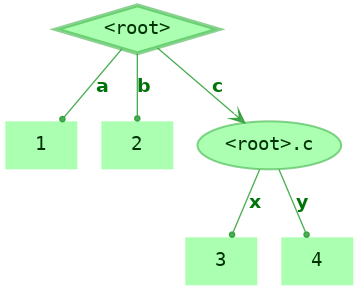

In [13]:
from treevalue import FastTreeValue, flatten, unflatten

origin_tree = FastTreeValue(origin)
origin_tree

In [14]:
flatted = flatten(origin_tree)
flatted

[(('a',), 1), (('b',), 2), (('c', 'x'), 3), (('c', 'y'), 4)]

Here is the performance of `flatten`

In [15]:
%timeit flatten(origin_tree)

952 ns ± 23.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


The tree can be re-created from `flatted` with function `unflatten`.

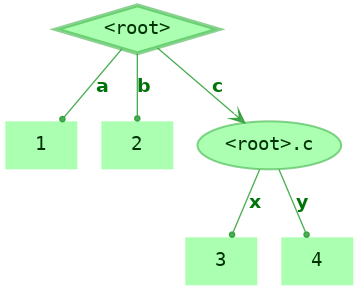

In [16]:
unflatten(flatted)

And here is the performance.

In [17]:
%timeit unflatten(flatted)

961 ns ± 20 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


### DM-Tree's Performance

[Flatten](https://tree.readthedocs.io/en/latest/api.html#tree.flatten) is provided in DM-Tree as well, but it differs from that in TreeValue, as the following

In [18]:
from tree import flatten

flatten(origin)

[1, 2, 3, 4]

Here is the performance

In [19]:
%timeit flatten(origin)

1.16 µs ± 12.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


The structure of the tree is dropped, only the data is extracted from the tree. This means the `flatten` function in DM-Tree is irreversible, we can not recover the original tree with the result above.

The reversible resolution provided in DM-Tree is [flatten_with_path](https://tree.readthedocs.io/en/latest/api.html#tree.flatten_with_path)

In [20]:
from tree import flatten_with_path

flatten_with_path(origin)

[(('a',), 1), (('b',), 2), (('c', 'x'), 3), (('c', 'y'), 4)]

Here is the performance, much slower than `flatten` in TreeValue.

In [21]:
%timeit flatten_with_path(origin)

19.3 µs ± 178 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


To re-create the original tree, we need a tree structure with any objects filled inside. Use the [unflatten_as](https://tree.readthedocs.io/en/latest/api.html#tree.unflatten_as) to archive this goal.

In [22]:
from tree import unflatten_as

unflatten_as({'a': None, 'b': None, 'c': {'x': None, 'y': None}}, [1, 2, 3, 4])

{'a': 1, 'b': 2, 'c': {'x': 3, 'y': 4}}

Here is the performance.

In [23]:
%timeit unflatten_as({'a': None, 'b': None, 'c': {'x': None, 'y': None}}, [1, 2, 3, 4])

15.2 µs ± 304 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Positional Replacement

It is obvious that the `unflatten_as` in DM-Tree is quite different from `unflatten` in TreeValue, for the former one is `replacing` and the latter one is `constructing`. This means the `unflatten_as` in DM-Tree may supported some more features, such as creating a new tree with another tree's structure and the given values. So we need an experiment on this, called 'positional replacement'.

First, in TreeValue, we can build a function named `replace` to realize this.

In [24]:
from treevalue import flatten, unflatten

def replace(t, v):
    pairs = flatten(t)
    return unflatten([(path, vi) for (path, _), vi in zip(pairs, v)])

Create a new tree based on `origin_tree`'s structure and new values.

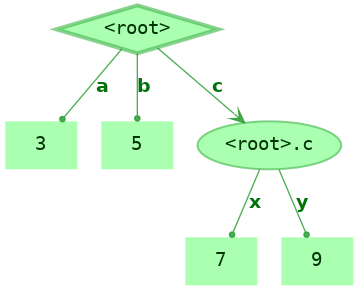

In [25]:
replace(origin_tree, [3, 5, 7, 9])

Here is the performance.

In [26]:
%timeit replace(origin_tree, [3, 5, 7, 9])

3.07 µs ± 78.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In DM-Tree, `unflatten_as` can be directly used.

In [27]:
from tree import unflatten_as

unflatten_as(origin, [3, 5, 7, 9])

{'a': 3, 'b': 5, 'c': {'x': 7, 'y': 9}}

Here is the performance, even much slower than the `replace` function for integration.

In [28]:
%timeit unflatten_as(origin, [3, 5, 7, 9])

14.8 µs ± 308 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Conclusion

The mapping operation is supported by both library, and `mapping` in TreeValue's performance is significantly higher than the `map_structure` and `map_structure_with_path` in DM-Tree.

The `flatten` and `unflatten` in TreeValue is reversible, but in DM-Tree not. DM-Tree's performance on flatten and unflatten operation is lower than that in TreeValue in all aspects.